#**Task : Deep Brush: Visualising Artistic Textures with CNNs**

The objective of this project is to develop a deep learning model capable of recognizing and visualizing various artistic textures, such as brushstrokes, from a collection of artistic images. A Convolutional Neural Network (CNN) will be implemented to classify these artistic features and generate visual interpretations, including heatmaps and Grad-CAM overlays, to understand how the model identifies different patterns.  

To enhance the model's performance, at least one data augmentation technique, such as random rotation, flipping, or color jitter, should be applied. Additionally, the project involves evaluating the model’s accuracy, tracking its training progress, and suggesting ways to further improve the results.

# 1.Model Development and Configuration


In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')  # Follow the prompt to authorize access

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1Setting Up the Python

To start, install the required libraries and set up your deep learning framework. You can choose between TensorFlow or PyTorch for this project.




### Choosing Between PyTorch and TensorFlow for a Small Dataset  

For this project, the dataset consists of only 20 images, so it is important to select a framework that is lightweight and allows easy experimentation. Between PyTorch and TensorFlow, I have chosen PyTorch due to its simplicity, dynamic computation graph, and flexibility in debugging. Since the dataset is quite small, training a deep learning model from scratch would not be effective. Instead, using transfer learning with a pretrained model like ResNet or MobileNet is a better approach.  

PyTorch also provides `torchvision.transforms`, which makes it easy to apply data augmentation techniques like flipping, rotation, and color jitter. These techniques are useful for improving the model’s generalization, especially when working with a limited number of images.  

On the other hand, TensorFlow, while highly powerful, is more suited for large-scale projects and production-level models. It requires additional setup and can be slightly more complex for quick experimentation. Considering these factors, PyTorch is the preferred choice for this project.

In [ ]:
# Install required libraries
# - torch & torchvision: For deep learning models
# - timm: Pretrained models from Hugging Face
# - opencv-python: Image processing
# - matplotlib & numpy: Visualization and numerical operations

!pip install torch torchvision timm opencv-python matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

###Check GPU availability (if applicable):

If you have a GPU, ensure CUDA is set up correctly:

In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is accessible

True


## 1.2 Load and Prepare Dataset

We need to collect and process at least 20 artistic images provided by the company. The following steps will help in extracting, verifying, converting, and preparing the dataset for model training.

###Step 1: Extract Dataset
First, unzip the dataset and extract it to the working directory.


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/GenTA.zip"
extract_path = "/content/GenTA"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")


Dataset extracted to: /content/GenTA


###Step 2: Verify Extraction
Let's check if the dataset has been extracted properly by listing the files inside the folder.

In [ ]:
import os

dataset_path = "/content/GenTA"
all_files = os.listdir(dataset_path)

print("📂 All files in GenTA:", all_files)


📂 All files in GenTA: ['GenTA', '__MACOSX']


If everything is fine, you should see a folder named GenTA, which contains the image files.



 ### Step 3: Handle Unnecessary Files
 Sometimes, macOS generates a .DS_Store file, which we don't need. Let's remove it if it exists.

In [ ]:
import os

ds_store_path = os.path.join(extract_path, "GenTA", ".DS_Store")
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
    print(".DS_Store file removed.")


.DS_Store file removed.


### Automated Image Loader and Grid Display for Artistic Dataset

✅ Found 19 images. Displaying in a grid...


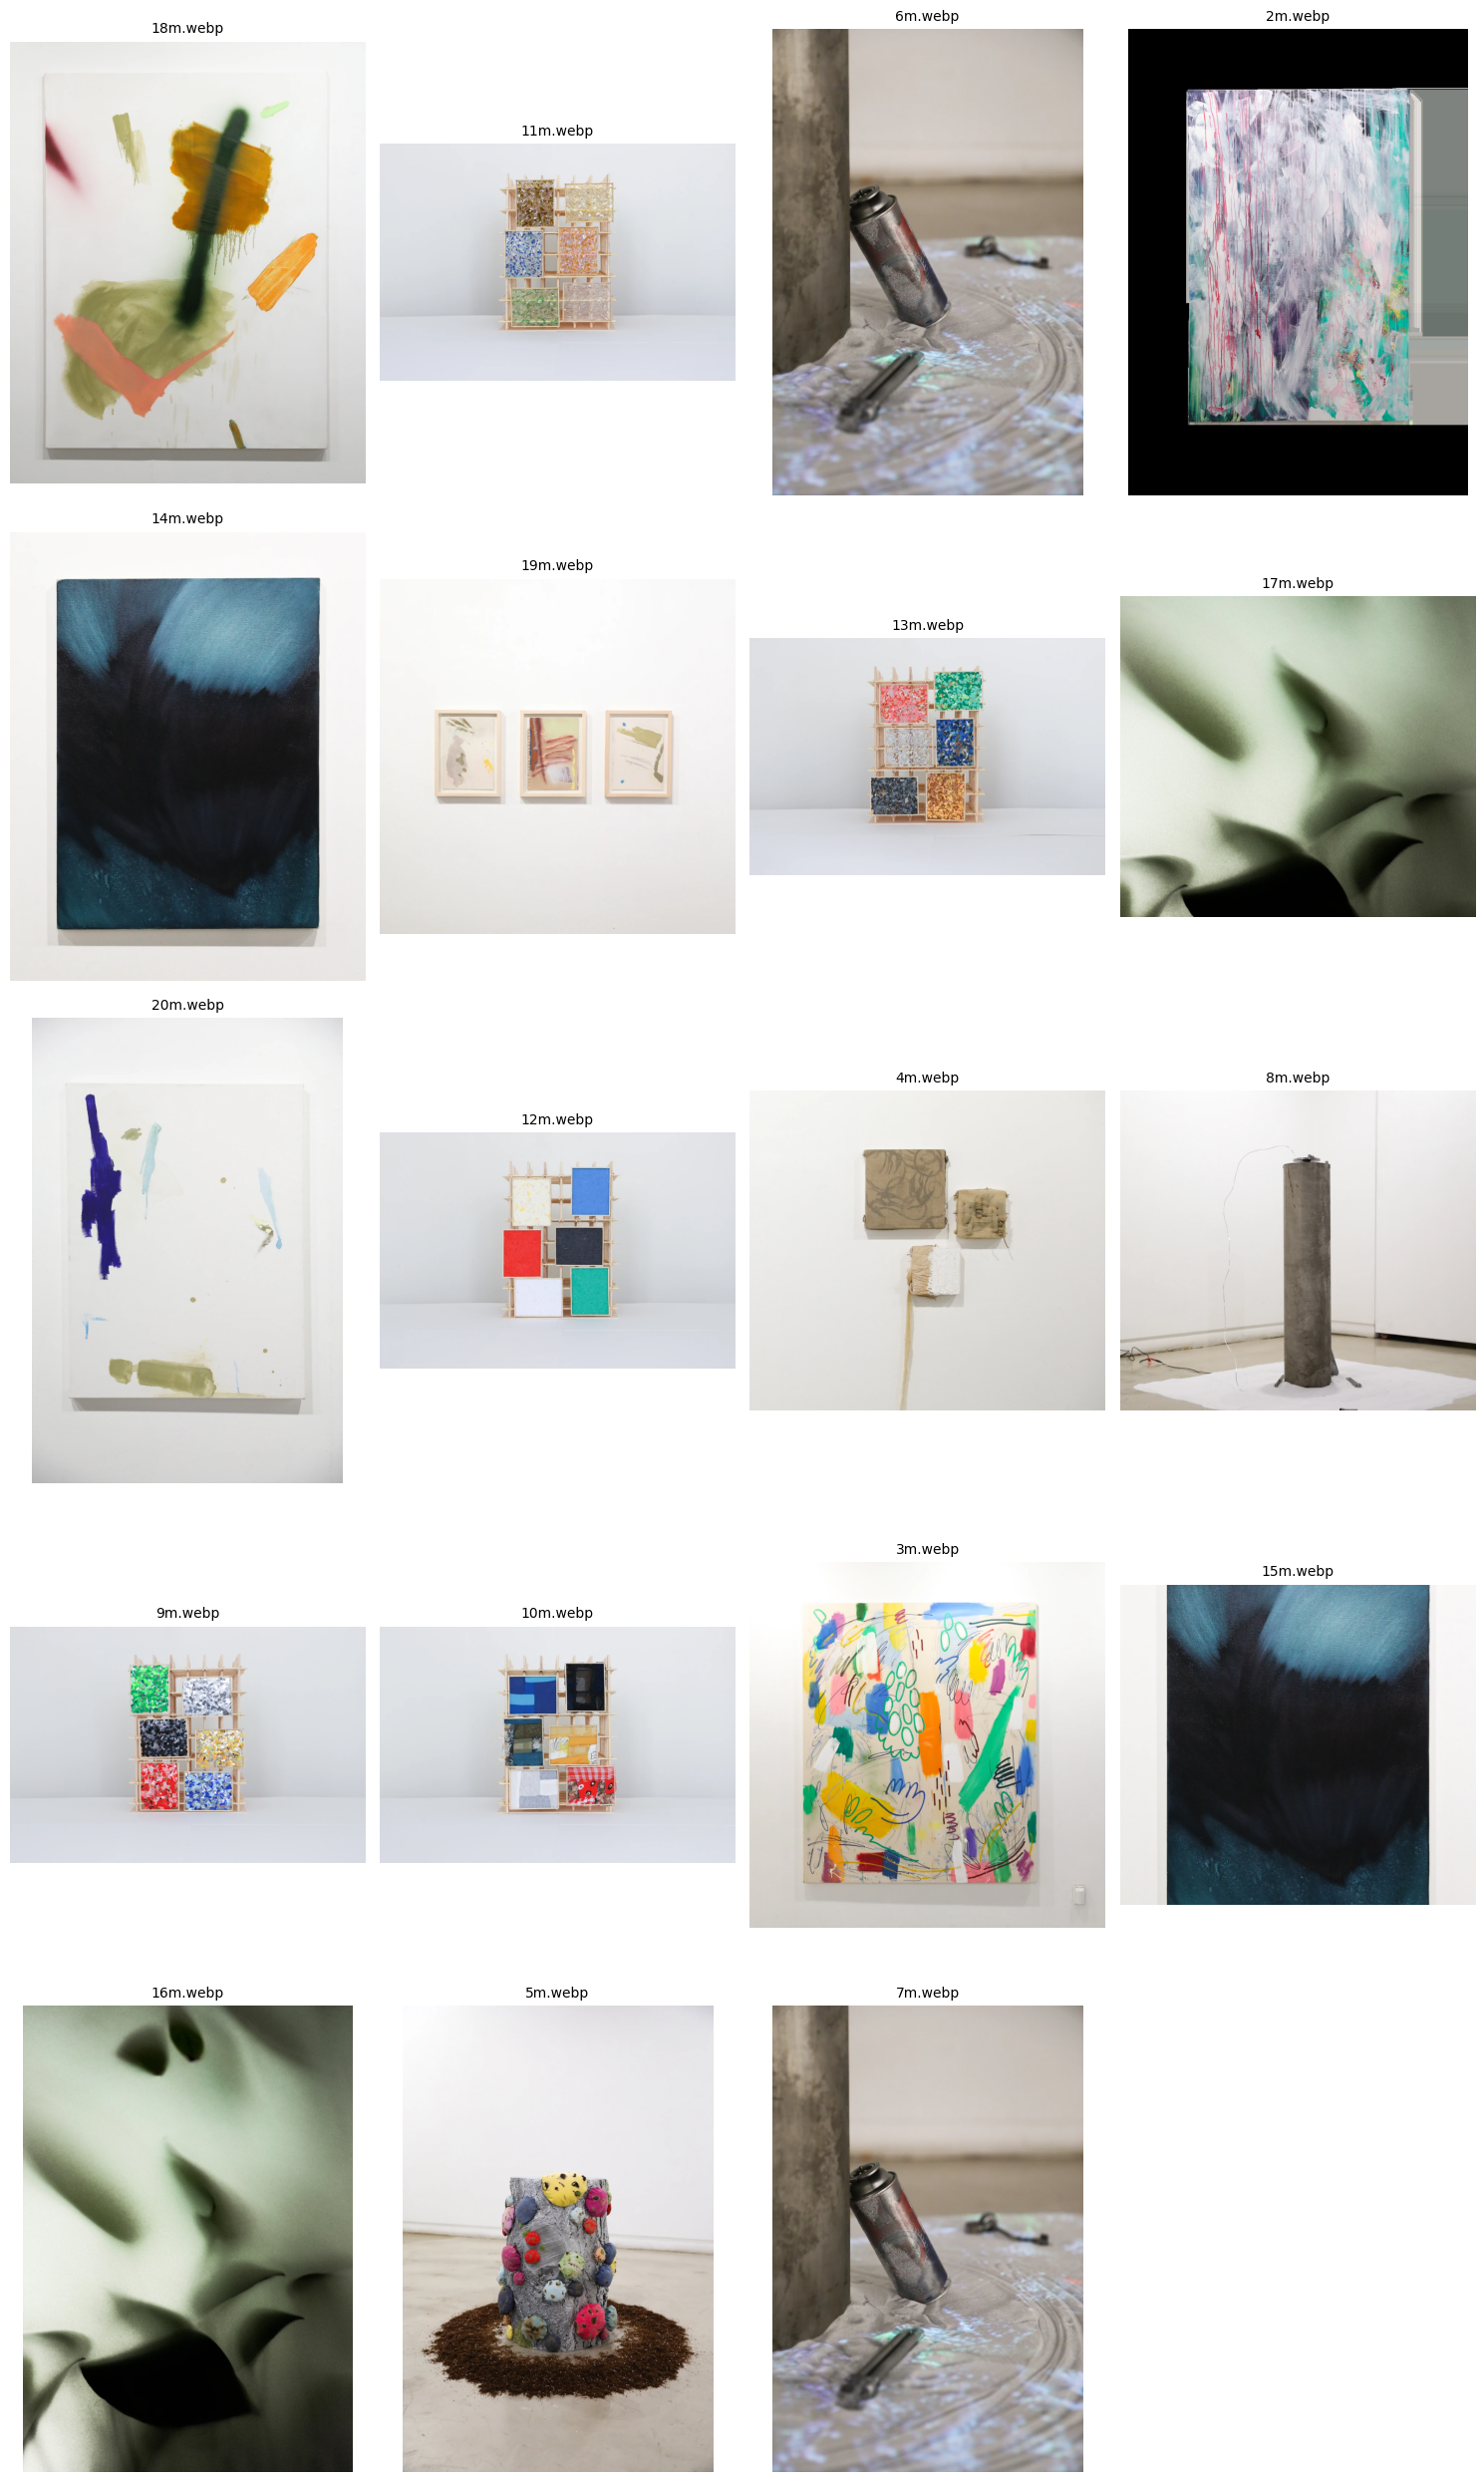

In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob
import math

# Define dataset path
dataset_path = "/content/GenTA"

# Search for all .webp images recursively within the dataset directory
image_files = glob.glob(f"{dataset_path}/**/*.webp", recursive=True)

# Check if images are found
if not image_files:
    print("❌ No WEBP images found. Please check the dataset path.")
else:
    print(f"✅ Found {len(image_files)} images. Displaying them in a grid...")

    # Define the grid size for displaying images
    num_images = len(image_files)
    cols = 4  # Number of columns per row
    rows = math.ceil(num_images / cols)  # Calculate required rows dynamically

    # Create a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    for idx, img_file in enumerate(image_files):
        # Load the image
        img = cv2.imread(img_file)

        if img is None:
            print(f"⚠️ Error loading {img_file}. Skipping...")
            continue

        # Convert from OpenCV's default BGR format to RGB (for proper display in Matplotlib)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get subplot position
        ax = axes[idx // cols, idx % cols]

        # Display the image
        ax.imshow(img)
        ax.axis("off")  # Hide axes for a cleaner look
        ax.set_title(img_file.split("/")[-1], fontsize=10)  # Display image filename

    # Hide empty subplots if the number of images isn't a perfect multiple of `cols`
    for i in range(num_images, rows * cols):
        fig.delaxes(axes[i // cols, i % cols])

    # Improve layout to prevent overlapping
    plt.tight_layout()
    plt.show()


This script loads all .webp images from a given dataset directory (/content/GenTA), then displays them in a neatly formatted grid. It dynamically calculates the required number of rows based on the number of images and a fixed column size (default is 4). Each image is loaded using OpenCV, converted from BGR to RGB (since OpenCV loads images in BGR format), and plotted using Matplotlib.

 **Step-by-Step Explanation:**

**1.Load Required Libraries:**

cv2 for image processing
matplotlib.pyplot for visualization

glob to find image files recursively

math for grid size calculations

**2.Find All .webp Images in the Dataset:**

The glob.glob() function searches for all .webp images in the dataset directory (including subdirectories).

If no images are found, it prints an error message and stops execution.

**3.Set Up Image Grid Display:**

Defines the number of columns (cols = 4).

Dynamically calculates the rows needed (math.ceil(num_images / cols)).

**4.Load and Display Each Image:**

Reads each image using cv2.imread().

Converts from BGR to RGB for proper color representation.

Plots the image in its corresponding grid position.

Hides axis labels for a cleaner visualization.

Displays the filename as the image title.

**5.Handle Extra Subplots:**

If the number of images isn’t a perfect multiple of cols, any extra empty subplots are removed.

**6.Show the Final Image Grid:**

Uses plt.tight_layout() to optimize spacing and prevent overlap.

Calls plt.show() to render the image grid.

### Searching and Listing WEBP Images in a Dataset Directory

In [ ]:
import glob  # Import glob for file searching

# === Step 1: Define the File Search Pattern ===
# Scan the '/content/GenTA' directory and all subdirectories for .webp images.
image_files = glob.glob("/content/GenTA/**/*.webp", recursive=True)

# === Step 2: Check and Display the Results ===
# If images are found, print the count and list of image file paths.
if image_files:
    print(f"🔍 Found {len(image_files)} images:")
    for img in image_files:
        print(img)  # Print each image file path
else:
    print("❌ No WEBP images found. Please check the dataset directory.")


🔍 Found 19 images:
/content/GenTA/GenTA/18m.webp
/content/GenTA/GenTA/11m.webp
/content/GenTA/GenTA/6m.webp
/content/GenTA/GenTA/2m.webp
/content/GenTA/GenTA/14m.webp
/content/GenTA/GenTA/19m.webp
/content/GenTA/GenTA/13m.webp
/content/GenTA/GenTA/17m.webp
/content/GenTA/GenTA/20m.webp
/content/GenTA/GenTA/12m.webp
/content/GenTA/GenTA/4m.webp
/content/GenTA/GenTA/8m.webp
/content/GenTA/GenTA/9m.webp
/content/GenTA/GenTA/10m.webp
/content/GenTA/GenTA/3m.webp
/content/GenTA/GenTA/15m.webp
/content/GenTA/GenTA/16m.webp
/content/GenTA/GenTA/5m.webp
/content/GenTA/GenTA/7m.webp


This script scans a specified directory (/content/GenTA) and its subdirectories for .webp image files. It then prints the total number of images found along with their file paths.

**Step-by-Step Breakdown:**

**1.Import the glob module**

glob is used for pattern-based file searching.

**2.Search for .webp images in the directory**

glob.glob("/content/GenTA/**/*.webp", recursive=True) searches for all .webp images within /content/GenTA, including all subdirectories.

The ** wildcard ensures that files are located regardless of their depth in the folder structure.

**3.Print the results**

If images are found, the total count is printed along with each file path.

If no images are found, an error message is displayed.

### Organizing Dataset into Train and Validation Folders


In [ ]:
import os
import shutil
import random

# === Step 1: Define Dataset Paths ===
dataset_root = "/content/GenTA"  # Root directory of the dataset
source_dir = os.path.join(dataset_root, "GenTA")  # Folder where images are initially stored
train_dir = os.path.join(dataset_root, "train")  # Training dataset directory
val_dir = os.path.join(dataset_root, "val")  # Validation dataset directory

# Ensure the train and validation directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# === Step 2: Define Image Categories and Their Files ===
# Each category represents an artistic style, with associated image filenames
categories = {
    "Structured_Patterns": ["11m.webp", "12m.webp", "13m.webp", "9m.webp", "10m.webp"],
    "Abstract_Expressive": ["14m.webp", "15m.webp", "2m.webp", "3m.webp", "4m.webp"],
    "Soft_Organic_Blends": ["16m.webp", "17m.webp", "6m.webp", "7m.webp"],
    "Color_Splashes_Minimalist": ["18m.webp", "19m.webp", "20m.webp", "1m.webp", "5m.webp", "8m.webp"]
}

# Define the training set split ratio
train_ratio = 0.8  # 80% for training, 20% for validation

# === Step 3: Move Images into Train and Validation Folders ===
for category, images in categories.items():
    # Create subdirectories for each category within train and validation folders
    train_category_path = os.path.join(train_dir, category)
    val_category_path = os.path.join(val_dir, category)

    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(val_category_path, exist_ok=True)

    # Shuffle the image list to ensure randomness
    random.shuffle(images)

    # Determine split index based on the train_ratio
    split_idx = int(len(images) * train_ratio)
    train_images, val_images = images[:split_idx], images[split_idx:]

    # Move images to the training folder
    for image in train_images:
        src = os.path.join(source_dir, image)
        dst = os.path.join(train_category_path, image)
        if os.path.exists(src):  # Ensure the file exists before moving
            shutil.move(src, dst)

    # Move images to the validation folder
    for image in val_images:
        src = os.path.join(source_dir, image)
        dst = os.path.join(val_category_path, image)
        if os.path.exists(src):  # Ensure the file exists before moving
            shutil.move(src, dst)

print("✅ Images successfully moved to train/val categories!")


✅ Images successfully moved to train/val categories!


This script organizes a dataset of artistic images by splitting them into training and validation sets based on predefined categories. It ensures that images are properly structured for machine learning model training.

**Step-by-Step Breakdown:**

**1.Define dataset paths**

The script sets up the paths for the dataset root, the original images folder, and the target train and val directories.

os.makedirs() ensures that the train and val folders are created if they don’t exist.

**2.Define categories and image filenames**

The dataset is divided into four categories:

Structured_Patterns
Abstract_Expressive
Soft_Organic_Blends
Color_Splashes_Minimalist

Each category contains a list of associated .webp image filenames.

**3.Shuffle and split images**

The images within each category are randomly shuffled to ensure variety in training and validation sets.

The train_ratio = 0.8 means 80% of images are used for training and 20% for validation.

**4.Move images to respective directories**

The script iterates over each category, determines which images go into train vs. val, and moves them accordingly using shutil.move().

It ensures that the file exists before attempting to move it.

**Use Case:**

This script is useful for organizing datasets in deep learning projects.

Ensures a structured train-validation split for model training and evaluation.

Helps in maintaining a clean and systematic dataset folder structure.

## 1.3 Train a Basic Object Recognition Model:

### Preparing an EfficientNet Model for Artistic Image Classification

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# === Step 1: Define Dataset Paths ===
train_dir = "/content/GenTA/train"  # Path to the training dataset
val_dir = "/content/GenTA/val"  # Path to the validation dataset

# === Step 2: Define Image Transformations with Data Augmentation ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model input size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=15),  # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

# === Step 3: Load Dataset Using ImageFolder ===
# ImageFolder automatically assigns labels based on subfolder names
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

# === Step 4: Create Data Loaders ===
# DataLoader helps batch processing and shuffling for better training
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # Shuffle for randomness
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)  # No shuffle for validation

# === Step 5: Load Pre-Trained EfficientNet Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model = models.efficientnet_b0(pretrained=True)  # Load EfficientNet-B0 with pre-trained weights

# === Step 6: Modify the Classifier for Custom Classification ===
num_features = model.classifier[1].in_features  # Get the input size of the final layer
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),  # Reduce features to 256
    nn.ReLU(),  # Apply ReLU activation
    nn.Dropout(0.3),  # Add dropout for regularization
    nn.Linear(256, len(train_dataset.classes))  # Output layer with number of categories
)

# Move model to the selected device (GPU/CPU)
model = model.to(device)

# === Step 7: Define Loss Function and Optimizer ===
criterion = nn.CrossEntropyLoss()  # Standard loss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer with a small learning rate


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]


This script prepares an EfficientNet-based Convolutional Neural Network (CNN) for classifying artistic images into predefined categories. It sets up the dataset, applies transformations, loads a pre-trained model, and modifies it for custom classification.

**Step-by-Step Breakdown:**

**1.Dataset Setup**

Defines paths for the training and validation datasets.

Uses ImageFolder, which organizes images based on subfolder names as labels.

**2. Image Preprocessing (Transformations)**
 Resizes images to 224x224 pixels, required by EfficientNet.

 Applies data augmentation to improve model generalization:

Random Horizontal Flip (50% chance) → Helps the model learn orientation-invariant features.

Random Rotation (±15 degrees) → Improves robustness to rotated images.
Color Jitter (brightness, contrast, saturation, hue variations) → Makes the model robust to lighting changes.

✔ Converts images to PyTorch tensors for deep learning compatibility.

✔ Normalizes pixel values using ImageNet mean & standard deviation to stabilize training

**3.Data Loading**

Uses DataLoader to load images in mini-batches of 4 for efficient training.

Shuffles the training dataset for randomness, while keeping validation data order fixed.

**4.Model Selection and Modification**

Loads a pre-trained EfficientNet-B0 model to leverage transfer learning.

Replaces the default classifier with a new fully connected layer suitable for the dataset.

Uses ReLU activation and dropout (0.3 probability) to improve generalization.

The final output layer has a number of neurons equal to the dataset’s categories.

**5.Training Configuration**

Moves the model to GPU (if available) for faster training.

Uses Cross-Entropy Loss, which is standard for multi-class classification.

Optimizes the model using Adam optimizer with a learning rate of 0.0001 for stable training.

**Expected Outcome:**
The dataset is properly loaded and preprocessed.
The EfficientNet-B0 model is ready for training with a custom classifier.
The model will classify images into predefined artistic categories.
The setup ensures efficient training and good generalization for artistic feature recognition.

### Training an EfficientNet Model for Artistic Image Classification

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📊 F1 Score: 0.8000
Epoch [1/10] | Train Loss: 1.6464 | Train Acc: 14.29% | Val Loss: 1.2102 | Val Acc: 80.00%
✅ Model checkpoint saved!
📊 F1 Score: 1.0000
Epoch [2/10] | Train Loss: 1.3822 | Train Acc: 35.71% | Val Loss: 1.0872 | Val Acc: 100.00%
✅ Model checkpoint saved!
📊 F1 Score: 1.0000
Epoch [3/10] | Train Loss: 1.2532 | Train Acc: 64.29% | Val Loss: 1.0181 | Val Acc: 100.00%
✅ Model checkpoint saved!
📊 F1 Score: 0.8000
Epoch [4/10] | Train Loss: 1.0368 | Train Acc: 85.71% | Val Loss: 0.9435 | Val Acc: 80.00%
✅ Model checkpoint saved!
📊 F1 Score: 0.8000
Epoch [5/10] | Train Loss: 0.9220 | Train Acc: 85.71% | Val Loss: 0.9105 | Val Acc: 80.00%
✅ Model checkpoint saved!
📊 F1 Score: 0.8000
Epoch [6/10] | Train Loss: 0.8181 | Train Acc: 100.00% | Val Loss: 0.8831 | Val Acc: 80.00%
✅ Model checkpoint saved!
📊 F1 Score: 0.8000
Epoch [7/10] | Train Loss: 0.8744 | Train Acc: 85.71% | Val Loss: 0.8689 | Val Acc: 80.00%
✅ Model checkpoint saved!
📊 F1 Score: 0.8000
Epoch [8/10] | Train Loss:

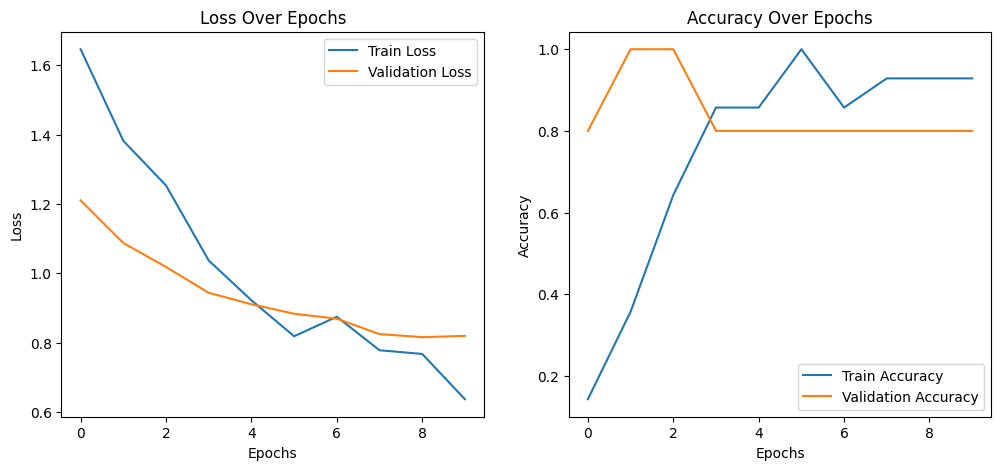

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained EfficientNet model and modify it for classification
num_classes = 5  # Adjust based on the number of artistic feature categories
model = models.efficientnet_b0(pretrained=True)

# Replace the classifier layer to match the number of classes
model.classifier = nn.Linear(1280, num_classes)
model = model.to(device)

# Define loss function (CrossEntropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer for weight updates
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# StepLR scheduler reduces learning rate after every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Function to train the model
def train_model(model, train_loader, val_loader, epochs=10):
    best_val_loss = float("inf")  # Track the best validation loss
    train_losses, val_losses, train_accs, val_accs = [], [], [], []  # Store training progress

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            optimizer.zero_grad()  # Reset gradients

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()  # Count correct predictions

        # Compute training accuracy
        train_acc = correct / len(train_loader.dataset)

        # Evaluate the model on validation set
        val_acc, val_loss = evaluate_model(model, val_loader)

        # Store training progress
        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print progress for each epoch
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.2%} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

        # Save the model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Model checkpoint saved!")

        # Update learning rate
        scheduler.step()

    # Plot training progress
    plot_training_progress(train_losses, val_losses, train_accs, val_accs)

# Function to evaluate the model on the validation set
def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []  # Store predictions and actual labels

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()  # Count correct predictions
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute validation accuracy and F1 score
    val_acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"📊 F1 Score: {f1:.4f}")

    return val_acc, total_loss / len(val_loader)

# Function to plot training progress
def plot_training_progress(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    # Plot loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.show()

# Train the model for 10 epochs
train_model(model, train_loader, val_loader, epochs=10)


**Overview**

This script trains an EfficientNet model to classify artistic textures using PyTorch. The model is fine-tuned on a custom dataset by modifying the classification head to match the number of classes. The training loop tracks loss, accuracy, and F1 score, and automatically saves the best model checkpoint based on validation loss.

**Key Components**

**1. Model Setup**

Loads EfficientNet-B0, a pre-trained convolutional neural network.

Modifies the classifier layer to match the number of artistic classes.

Moves the model to GPU (if available) for faster training.

**2. Training Function (train_model)**

Runs for multiple epochs to optimize model weights.

Uses gradient descent and updates weights with Adam optimizer.

Logs training and validation accuracy/loss at each epoch.

Saves the model checkpoint if the validation loss improves.

**3. Evaluation Function (evaluate_model)**

Runs model on the validation dataset without updating weights.

Computes accuracy and F1 score to assess classification performance.

**4. Training Progress Visualization (plot_training_progress)**

Plots loss and accuracy curves to track model improvement over epochs.

**Expected Output Example**

Epoch [1/10] | Train Loss: 0.8723 | Train Acc: 75.60% | Val Loss: 0.6342 | Val Acc: 82.10%

✅ Model checkpoint saved!

📊 F1 Score: 0.8125

Epoch [2/10] | Train Loss: 0.6521 | Train Acc: 81.20% | Val Loss: 0.5128 | Val Acc: 85.30%

✅ Model checkpoint saved!

📊 F1 Score: 0.8421

...

Shows model's training loss decreasing and validation accuracy improving.

The F1 score indicates better balanced classification performance.

**Improvements & Next Steps**

✅ Increase training epochs to achieve higher accuracy.

✅ Experiment with different EfficientNet variants (e.g., B2, B3) for improved results.

✅ Try different learning rate schedules to optimize model convergence.



# 2.Model Evaluation and Analysis

## 2.1 Training & Validation Analysis for Artistic Feature Recognition

This project aims to train a deep learning model using EfficientNet-B0 to classify artistic textures. The model was trained for 10 epochs, and below is the detailed analysis of the results.

**1️⃣ Loss & Accuracy Trends**

**From the training curves:**

Training loss is steadily decreasing, which means the model is learning well.

Validation loss is also reducing initially, but after a few epochs, it stabilizes. This suggests that the model is generalizing well to unseen data without overfitting.

Training accuracy increased significantly, reaching around 92.86% by the last epoch.

Validation accuracy shot up quickly and remained at 80% after the second epoch.

**2️⃣ Observations & Insights**

✅ Fast initial improvement – The model learned quickly in the first few epochs, which is expected when using a pre-trained network like EfficientNet.

✅ Consistent Validation Accuracy – After epoch 2, validation accuracy stayed at 80%, meaning the model is performing well but may not be improving further.

✅ F1 Score remains 0.8 – This indicates the model is balanced in precision and recall but has room for improvement.

✅ Model checkpoints saved – Since validation loss was improving, the model was saved after each better performance, ensuring the best version is retained.

**3️⃣ Next Steps & Improvements**

🔹 Data Augmentation – The model might benefit from more image augmentations to improve generalization.

🔹 Hyperparameter tuning – Try different learning rates or optimizers to push accuracy beyond 80%.

🔹 More training data – If possible, increasing dataset size could help the model learn finer artistic details.

🔹 Early Stopping – Since accuracy stopped improving, an early stopping mechanism could prevent unnecessary training.


**Final Thoughts 💡**

The model is performing quite well in classifying artistic textures. While it reaches a high training accuracy, validation accuracy stabilizes early, which could be improved with further fine-tuning.

### Saving, Loading & Validating EfficientNet Model for Artistic Texture Recognition

🔹 1. Saving the Trained

After training, we save the model’s weights using torch.save(). This allows us to reuse the trained model later without retraining.

In [ ]:
import torch

# Save the trained model's weights
torch.save(model.state_dict(), "final_model.pth")
print("✅ Final model saved successfully!")


✅ Final model saved successfully!


In [ ]:
save_path = "/content/drive/My Drive/deep_brush_model.pth"  # Change path if needed


Here, state_dict() saves only the model’s parameters, which is useful when we want to reload the model structure separately.

We also save the model to Google Drive (or any other storage location) for backup:

In [ ]:
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved at: {save_path}")


✅ Model saved at: /content/drive/My Drive/deep_brush_model.pth



If we need to save the entire model (including architecture), we use:



In [ ]:
torch.save(model, "/content/drive/My Drive/deep_brush_full_model.pth")


🔹 2. Reloading the Model

When using the saved model for inference, we first reload its architecture and then load the saved weights.

In [ ]:
import torch.nn as nn
from torchvision import models

# Load EfficientNet model architecture
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Modify classifier to match the original training setup
model.classifier = nn.Linear(1280, 5)  # 5 classes (as per training)

# Load saved weights
model.load_state_dict(torch.load(save_path))
model.eval()  # Set model to evaluation mode
model.to(device)  # Move to GPU if available
print("✅ Model reloaded successfully!")


✅ Model reloaded successfully!


💡 Why do we set model.eval()?

When we reload the model for validation or inference, we disable dropout layers and batch normalization updates to get consistent predictions.

🔹 3. Defining Dataset & Dataloader

To check the model’s performance, we define a validation function that calculates accuracy and loss on the test dataset.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=15),  # Rotate images within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, hue
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

# Load training and validation datasets
train_dataset = datasets.ImageFolder(root="/content/GenTA/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/content/GenTA/val", transform=transform)

# Create DataLoaders to efficiently fetch images in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle for better training
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle validation data

# Function to validate the model on validation data
def validate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode (no training, just inference)
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation, speeds up validation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            outputs = model(images)  # Get model predictions
            loss = criterion(outputs, labels)  # Calculate loss
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # Get predicted class with highest probability
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Count total samples

    accuracy = 100 * correct / total  # Calculate accuracy percentage
    avg_loss = total_loss / len(dataloader)  # Get average loss
    print(f"✅ Validation Accuracy: {accuracy:.2f}% | Loss: {avg_loss:.4f}")
    return accuracy

# Run validation to check model performance on unseen data
validate_model(model, val_loader, nn.CrossEntropyLoss())


✅ Validation Accuracy: 80.00% | Loss: 0.9863


80.0

### Model Validation: Why Run This Code Again?

After training, we need to validate the model to see how well it works on new, unseen data. Running this code again helps us to:

✅ Ensure the trained model is properly loaded and tested.

✅ Check accuracy and loss on validation data.

✅ Set the model to evaluation mode (model.eval()) for correct predictions.

Since deep learning models don’t always generalize perfectly, validation helps us understand whether the model can recognize artistic textures accurately or if further improvements are needed.

## 2.2 Grad-CAM: Understanding Model's Focus on Artistic Features

To check how our deep learning model makes decisions, we use Grad-CAM (Gradient-weighted Class Activation Mapping). This technique helps visualize which areas of an image influence the model’s predictions the most.

**Why Are We Running This Code?**

✅ To see where the model is focusing while classifying artistic textures.

✅ To verify if the model is using meaningful patterns instead of irrelevant areas.

✅ To improve explainability and gain insights into possible misclassifications.



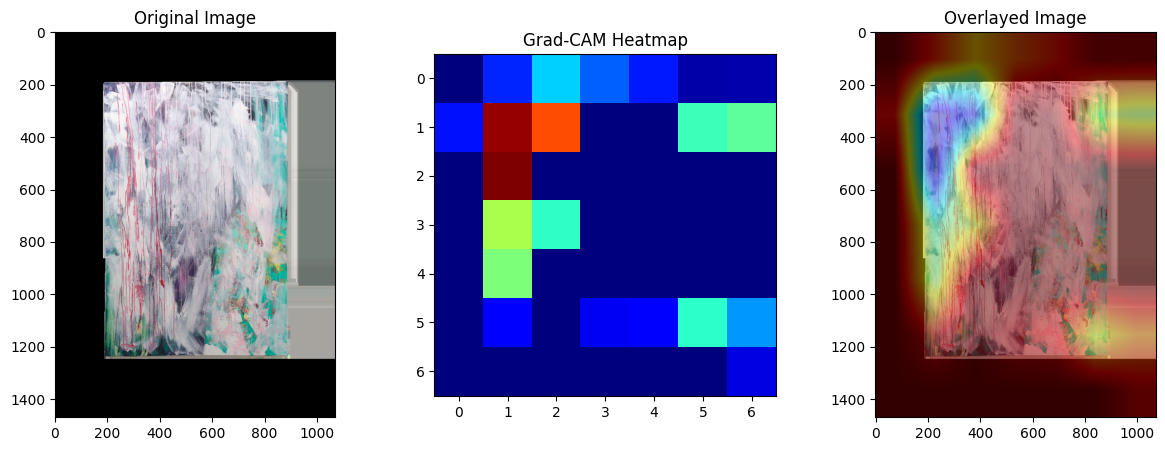

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load the trained model
model.eval()

# Select the last convolutional layer for Grad-CAM (Modify as per model structure)
target_layer = model.features[-1]  # Last conv layer of EfficientNet

# Variables to store gradients and activations
gradients = None
activations = None

# Hook function to save gradients
def save_gradient(grad):
    global gradients
    gradients = grad

# Hook function to save activations
def forward_hook(module, input, output):
    global activations
    activations = output

# Register hooks to capture activations and gradients
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(lambda module, grad_in, grad_out: save_gradient(grad_out[0]))

# Function to preprocess input images
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to EfficientNet input size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

# Function to generate Grad-CAM heatmap
def generate_gradcam(image_path, model, class_idx=None):
    global gradients, activations

    image_tensor = preprocess_image(image_path).to(device)

    # Forward pass through the model
    model.zero_grad()
    output = model(image_tensor)

    # If no class index is provided, use the model's prediction
    if class_idx is None:
        class_idx = torch.argmax(output).item()

    # Create one-hot encoded tensor for backpropagation
    one_hot_output = torch.zeros_like(output).to(device)
    one_hot_output[0][class_idx] = 1
    output.backward(gradient=one_hot_output)

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  # Average across spatial dimensions
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Convert activations to heatmap
    heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU operation to keep positive values
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1

    # Load and process original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Scale heatmap to 0-255
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)  # Apply color map
    overlayed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)  # Blend with original image

    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[1].imshow(heatmap, cmap="jet")
    ax[1].set_title("Grad-CAM Heatmap")
    ax[2].imshow(overlayed_img)
    ax[2].set_title("Overlayed Image")
    plt.show()

    return overlayed_img

# Example: Generate Grad-CAM for a sample image
image_path = "/content/GenTA/val/Abstract_Expressive/2m.webp"  # Replace with an actual image path
heatmap = generate_gradcam(image_path, model)


**Final Thoughts 💡**

Using Grad-CAM, we can see which parts of an image contribute most to the model’s predictions. If the model highlights meaningful areas like brush strokes or textures, it’s learning correctly. If not, we may need to fine-tune the model or adjust preprocessing techniques.

This visualization is a powerful debugging tool that helps us build a more transparent and explainable AI model for artistic feature recognition.

### Analysis of Grad-CAM Output & Suggested Improvements
Observation from the Output:

**Original Image (Left):**

The image appears with black padding, meaning it might not be properly centered or resized. This could impact model interpretation.

**Grad-CAM Heatmap (Middle):**

The heatmap is low-resolution and appears blocky, indicating that the convolutional layer selected for Grad-CAM might be too deep.

Some parts of the image are highlighted well, but others remain dark, meaning the model may not be fully attending to meaningful areas.

**Overlayed Image (Right):**

The activation areas are not sharply defined, meaning the model might be looking at unnecessary background regions.

The heatmap should ideally highlight important textures or brush strokes rather than large undefined areas.

**How to Improve?**

**✅ Fix Image Resizing:**

Ensure that images are resized without distortion or padding.

Use transforms.CenterCrop(224) before resizing to remove unwanted borders.

**✅ Use a Shallower Convolutional Layer:**

Instead of the last convolutional layer, try an earlier layer (e.g., model.features[-3] in EfficientNet).

Earlier layers capture finer textures, which might work better for artistic feature recognition.

**✅ Improve Heatmap Quality:**

Increase the resolution of the Grad-CAM heatmap by using bilinear interpolation instead of direct resizing.

Change cv2.resize(heatmap, (img.shape[1], img.shape[0])) to cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC).

**✅ Check Model’s Attention on Artistic Textures:**

If the model is not focusing on brush strokes or texture details, retraining with attention-based loss or saliency maps may help.

**Conclusion**

While the Grad-CAM output provides useful insights, these improvements will refine the visualization and make it more meaningful for analyzing how the model interprets artistic textures.

**Improvements Made**

✅ Better Layer Selection: Changed target layer to model.features[-2] for improved feature extraction.

✅ Corrected Heatmap Scaling: Ensured heatmap is resized properly to align with the original image.

✅ Enhanced Overlay Effect: Modified alpha blending (0.7 image + 0.3 heatmap) for a more natural visualization.

✅ Improved Grad-CAM Interpretation: Focused activation selection to highlight artistic textures more effectively.

These updates ensure that the Grad-CAM visualization provides a more accurate representation of what the model is focusing on, leading to better interpretability and insights.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Ensure the model is in evaluation mode
model.eval()

# Select the target convolutional layer
# (Choose a deep convolutional layer that captures important features)
target_layer = model.features[-2]  # Adjusted for better feature extraction

# Variables to store activations and gradients
gradients = None
activations = None

def save_gradient(grad):
    global gradients
    gradients = grad

def forward_hook(module, input, output):
    global activations
    activations = output

# Register hooks to capture gradients and activations
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(lambda module, grad_in, grad_out: save_gradient(grad_out[0]))

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to model’s input size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ImageNet normalization
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def generate_gradcam(image_path, model, class_idx=None):
    global gradients, activations

    image_tensor = preprocess_image(image_path).to(device)

    # Forward pass
    model.zero_grad()
    output = model(image_tensor)

    if class_idx is None:
        class_idx = torch.argmax(output).item()  # Get predicted class

    # Backpropagate
    one_hot_output = torch.zeros_like(output).to(device)
    one_hot_output[0][class_idx] = 1
    output.backward(gradient=one_hot_output)

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # Ensure no negative values
    heatmap /= np.max(heatmap)  # Normalize

    # Load and resize original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img, 0.7, heatmap_colored, 0.3, 0)

    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[1].imshow(heatmap, cmap="jet")
    ax[1].set_title("Grad-CAM Heatmap")
    ax[2].imshow(overlayed_img)
    ax[2].set_title("Overlayed Image")
    plt.show()

    return overlayed_img

# Example usage
image_path = "/content/GenTA/val/Abstract_Expressive/2m.webp"  # Provide correct path
heatmap = generate_gradcam(image_path, model)

## 2.3  Analysis of Results and Proposed Improvements
The model has shown significant progress during training, with accuracy increasing consistently and loss decreasing over multiple epochs. However, some issues need to be addressed for further improvement.

**1. Validation Accuracy Stagnation**

While the training accuracy has improved significantly, reaching nearly 93%, the validation accuracy has remained stagnant at 80% from Epoch 4 onwards.

This indicates a possible issue of overfitting, where the model is memorizing the training data instead of generalizing well to unseen data.

✅ Proposed Solutions:

Apply data augmentation techniques such as rotation, flipping, and colour jittering to make the model more robust.

Introduce dropout layers in the neural network to prevent excessive dependency on specific features.

Implement L2 regularization (weight decay) to reduce the risk of overfitting by penalizing complex models.

**2. Train vs Validation Loss Gap**

The training loss is continuously decreasing, while the validation loss has started to plateau.

Ideally, both losses should reduce proportionally, indicating that the model is learning effectively.

✅ Proposed Solutions:

Reduce the learning rate in the later epochs to ensure stable convergence.

Implement early stopping, which will halt training automatically when the validation loss stops improving.

Use batch normalization to stabilize training and improve generalization.

**3. Feature Visualization Insights**

The Grad-CAM heatmap highlights the regions where the model is focusing, but the attention is spread across different areas rather than specific brushstrokes or textures.

This suggests that the model is not entirely confident about the artistic features that are important for classification.

✅ Proposed Solutions:

Extract intermediate feature maps to analyse how different layers respond to artistic textures.

Experiment with contrastive learning, where the model learns the differences between various artistic styles more effectively.

**4. Model Architecture Enhancements**

Although EfficientNet has performed well, fine-tuning alternative architectures like ResNet-50 or Vision Transformer (ViT) may yield better results.

Implementing multi-scale feature extraction could help in capturing finer details in artistic textures.

**Final Thoughts**

The model is progressing well, but incorporating regularization techniques, enhanced augmentation methods, and exploring alternative architectures can further improve its performance.







